In [27]:
pip install dtaidistance

In [28]:
import math, time, re
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import matplotlib.pyplot as plt

In [29]:
BASE_DIR=Path("/content/drive/MyDrive/Dance_clean_data")

In [30]:
SEQ_IN,SEQ_OUT=30,30
BATCH_TRAIN=128
BATCH_EVAL=64
EPOCHS=10
LR=2e-4
WDECAY=0.0
GRAD_CLIP=1.0
DIFF_STEPS_TRAIN=400
SAMPLE_STEPS=100
GUIDE_W=2.0
DROP_P_CTX=0.10
DROP_P_LBL=0.10
WINDOW_STRIDE_EVAL=10
MAX_EVAL_WINDOWS=20000
MAX_DTW_SAMPLES=64
N_SAMPLES_PER_WIN=1
VEL_W=0.10

In [31]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP=torch.cuda.is_available()
torch.backends.cudnn.benchmark=True
try: torch.set_float32_matmul_precision('high')
except: pass

In [32]:
def dancer_from_path(p: Path):
    m=re.match(r"^(D\d+)",p.parent.name)
    return m.group(1) if m else p.parent.name

def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)

In [33]:
def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)

In [34]:
def build_io(data_2d,in_len=30,out_len=30,feat_dim=None,stride=1):
    T=len(data_2d)
    if feat_dim is None: feat_dim=data_2d.shape[1] if data_2d.ndim==2 else 0
    if T<in_len+out_len:
        return (np.empty((0,in_len,feat_dim),np.float32),
                np.empty((0,out_len,feat_dim),np.float32))
    X,Y=[],[]
    for i in range(0,T-in_len-out_len+1,stride):
        X.append(data_2d[i:i+in_len])
        Y.append(data_2d[i+in_len:i+in_len+out_len])
    return np.stack(X).astype(np.float32),np.stack(Y).astype(np.float32)

In [35]:
def fit_scaler(X_windows):
    sc=StandardScaler().fit(X_windows.reshape(-1, X_windows.shape[-1]))
    mu,sig=sc.mean_.astype(np.float32),sc.scale_.astype(np.float32)
    sig[sig==0]=1.0
    return mu, sig

def transform_safe(x,mu,sig): return (x - mu)/sig
def inv_transform_safe(x, mu, sig): return x*sig+mu

def vel(x):
    return x[:,1:,:]-x[:,:-1,:]

In [36]:
train_by_d=load_npy_by_pattern(BASE_DIR,"train")
zig_by_d=load_npy_by_pattern(BASE_DIR,"zigzag")
circ_by_d=load_npy_by_pattern(BASE_DIR,"circle")
all_ds=sorted(set(train_by_d)|set(zig_by_d)|set(circ_by_d))
D_group={f"D{i}" for i in range(1,6)}
N_group= {f"D{i}" for i in range(6,11)}

In [37]:
def concat_group(b, ids):
    if not b: return np.empty((0,0), np.float32)
    any_d = next(iter(b))
    Ddim=b[any_d][0].shape[1]
    return vstack_or_empty([arr for d in ids for arr in b.get(d, [])], D=Ddim)

train_D=concat_group(train_by_d,D_group)
train_N=concat_group(train_by_d,N_group)
zig_D=concat_group(zig_by_d,D_group)
zig_N=concat_group(zig_by_d,N_group)
circ_D=concat_group(circ_by_d,D_group)
circ_N=concat_group(circ_by_d,N_group)

print("Shapes– train(D):", train_D.shape, " train(N):", train_N.shape," zig(D):", zig_D.shape, " zig(N):", zig_N.shape,
      " circle(D):", circ_D.shape, " circle(N):", circ_N.shape)

if train_D.size>0: D=train_D.shape[1]
elif train_N.size>0: D=train_N.shape[1]
else: raise RuntimeError("No train .npy found.")

Shapes– train(D): (167564, 112)  train(N): (163944, 112)  zig(D): (67560, 112)  zig(N): (64474, 112)  circle(D): (71661, 112)  circle(N): (66863, 112)


In [38]:
def train_windows(long_arr,name):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=D,stride=1)
    print(f"{name} windows:", Xr.shape, Yr.shape)
    n=len(Xr)
    if n==0:
        Z=(np.empty((0,SEQ_IN,D),np.float32),)*2 + (np.empty((0,SEQ_IN,D),np.float32),)*2
        return Z
    n_val=max(int(0.1*n), 1)
    return Xr[:-n_val],Yr[:-n_val],Xr[-n_val:],Yr[-n_val:]

Xtr_D,Ytr_D,Xval_D,Yval_D=train_windows(train_D, "Train(GroupD)")
Xtr_N,Ytr_N,Xval_N,Yval_N=train_windows(train_N, "Train(GroupN)")

Train(GroupD) windows: (167505, 30, 112) (167505, 30, 112)
Train(GroupN) windows: (163885, 30, 112) (163885, 30, 112)


In [39]:
mu_D,sig_D=fit_scaler(Xtr_D)
mu_N,sig_N=fit_scaler(Xtr_N)
Xtr_Dn=transform_safe(Xtr_D,mu_D,sig_D); Ytr_Dn=transform_safe(Ytr_D,mu_D,sig_D)
Xval_Dn=transform_safe(Xval_D,mu_D,sig_D); Yval_Dn=transform_safe(Yval_D,mu_D,sig_D)
Xtr_Nn=transform_safe(Xtr_N,mu_N,sig_N); Ytr_Nn=transform_safe(Ytr_N,mu_N,sig_N)
Xval_Nn=transform_safe(Xval_N,mu_N,sig_N); Yval_Nn=transform_safe(Yval_N,mu_N,sig_N)
ctx_last_D_tr=Xtr_Dn[:,-1,:]
ctx_last_D_val=Xval_Dn[:,-1,:]
Ytr_D_resid=Ytr_Dn-ctx_last_D_tr[:,None,:]
Yval_D_resid=Yval_Dn-ctx_last_D_val[:,None,:]
ctx_last_N_tr=Xtr_Nn[:,-1,:]
ctx_last_N_val=Xval_Nn[:,-1,:]
Ytr_N_resid=Ytr_Nn-ctx_last_N_tr[:,None,:]
Yval_N_resid=Yval_Nn-ctx_last_N_val[:,None,:]

lbl_D_tr=np.ones (len(Xtr_Dn),np.int64)
lbl_D_val=np.ones (len(Xval_Dn),np.int64)
lbl_N_tr=np.zeros(len(Xtr_Nn),np.int64)
lbl_N_val=np.zeros(len(Xval_Nn),np.int64)

In [40]:
def cosine_beta_schedule(T,s=0.008):
    steps=T+1
    x=torch.linspace(0,T,steps,dtype=torch.float32)
    alphas_cumprod=torch.cos(((x/T)+s)/(1+s)*math.pi/2)**2
    alphas_cumprod=alphas_cumprod/alphas_cumprod[0]
    betas=1-(alphas_cumprod[1:]/alphas_cumprod[:-1])
    return torch.clip(betas,1e-6,0.999)

class DiffusionSchedule:
    def __init__(self, T, device):
        self.T=T
        self.device=device
        self.betas=cosine_beta_schedule(T).to(device)
        self.alphas=1.0-self.betas
        self.alphas_bar=torch.cumprod(self.alphas,dim=0)

    def q_sample(self,x0,t,noise):
        a_bar=self.alphas_bar[t].view(-1,1,1)
        return torch.sqrt(a_bar)*x0+torch.sqrt(1.0-a_bar)*noise

In [41]:
def sinusoidal_embedding(timesteps,dim):
    device=timesteps.device
    half=dim//2
    freqs=torch.exp(torch.linspace(0,1,half,device=device)*(-math.log(10000.0)))
    args=timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb=torch.cat([torch.sin(args),torch.cos(args)],dim=1)
    if dim%2==1: emb=torch.nn.functional.pad(emb,(0,1))
    return emb

In [42]:
class FiLMedResBlock(nn.Module):
    def __init__(self,C):
        super().__init__()
        self.n1=nn.GroupNorm(8,C)
        self.n2=nn.GroupNorm(8,C)
        self.act=nn.SiLU()
        self.c1=nn.Conv1d(C,C,3,padding=1)
        self.c2=nn.Conv1d(C,C,3,padding=1)
        self.to_gamma_beta=nn.Linear(C,2*C)

    def forward(self,x,cond_vec):
        gb=self.to_gamma_beta(cond_vec)
        gamma,beta=gb.chunk(2,dim=1)
        gamma=gamma.unsqueeze(-1); beta=beta.unsqueeze(-1)
        h=self.c1(self.act(self.n1(x)))
        h=(1+gamma)*h+beta
        h=self.c2(self.act(self.n2(h)))
        return x+h


In [43]:
class ContextEncoder(nn.Module):
    def __init__(self,in_dim,base=128):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv1d(in_dim,base,3,padding=1),
            nn.GroupNorm(8,base),
            nn.SiLU(),
            nn.Conv1d(base,base,3,padding=1),
            nn.GroupNorm(8,base),
            nn.SiLU(),
        )
    def forward(self,ctx_seq):
        x=ctx_seq.permute(0,2,1)
        h=self.net(x)
        g=h.mean(dim=-1)
        return g

In [44]:
class Diffusion(nn.Module):
    def __init__(self,in_dim,base=128,nblocks=6,t_dim=128,lbl_dim=64,ctx_dim=128):
        super().__init__()
        self.proj_in=nn.Conv1d(in_dim,base,1)
        self.blocks=nn.ModuleList([FiLMedResBlock(base) for _ in range(nblocks)])
        self.proj_out=nn.Conv1d(base, in_dim, 1)

        self.t_mlp= nn.Sequential(nn.Linear(t_dim, base), nn.SiLU(), nn.Linear(base, base))
        self.lbl_emb=nn.Embedding(3,lbl_dim)
        self.lbl_mlp=nn.Sequential(nn.Linear(lbl_dim,base), nn.SiLU(), nn.Linear(base, base))
        self.ctx_enc=ContextEncoder(in_dim, base=ctx_dim)
        self.ctx_mlp=nn.Sequential(nn.Linear(ctx_dim,base), nn.SiLU(), nn.Linear(base, base))

        self.t_dim=t_dim

    def forward(self, x_t, ctx_seq, label, t):
        B,Lout,Din=x_t.shape
        x=x_t.permute(0,2,1)
        h=self.proj_in(x)

        te=sinusoidal_embedding(t, self.t_dim).to(x_t.dtype)
        te=self.t_mlp(te)
        le=self.lbl_mlp(self.lbl_emb(label.clamp(0,2)))
        ce=self.ctx_mlp(self.ctx_enc(ctx_seq))
        cond=te+le+ce

        for blk in self.blocks:
            h=blk(h,cond)

        out = self.proj_out(h)
        return out.permute(0,2,1)

In [45]:
class DiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, X_ctx, Y_resid, labels):
        self.X = X_ctx; self.Y = Y_resid; self.L = labels
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i], self.L[i]

In [46]:
def train_diffusion(Xtr,Ytr_resid,lbl_tr,Xval,Yval_resid,lbl_val,d_feat,tag=""):
    sched=DiffusionSchedule(DIFF_STEPS_TRAIN,device=DEVICE)
    model=Diffusion(in_dim=d_feat,base=128,nblocks=6,t_dim=128,lbl_dim=64,ctx_dim=128).to(DEVICE)
    opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WDECAY)
    loss_pos=nn.SmoothL1Loss()
    scaler=torch.amp.GradScaler("cuda", enabled=AMP)
    train_ds=DiffusionDataset(Xtr,Ytr_resid,lbl_tr)
    val_ds=DiffusionDataset(Xval,Yval_resid,lbl_val)
    train_loader=DataLoader(train_ds,batch_size=BATCH_TRAIN,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_ds,batch_size=BATCH_TRAIN,shuffle=False,drop_last=False)

    print(f"\nTraining:")
    for ep in range(1, EPOCHS+1):
        model.train(); t0=time.time(); tot=0.0
        for xb,y0,lb in train_loader:
            xb=xb.to(DEVICE); y0=y0.to(DEVICE); lb=lb.to(DEVICE)
            Bn=xb.size(0)
            t=torch.randint(0,sched.T,(Bn,),device=DEVICE)
            lb_train=lb.clone()
            drop_lbl=(torch.rand(Bn,device=DEVICE)<DROP_P_LBL)
            lb_train[drop_lbl]=2
            xb_ctx=xb.clone()
            drop_ctx=(torch.rand(Bn,device=DEVICE)<DROP_P_CTX).float().view(Bn,1,1)
            xb_ctx=xb_ctx*(1.0-drop_ctx)
            noise=torch.randn_like(y0)
            with torch.amp.autocast("cuda",enabled=AMP):
                x_t=sched.q_sample(y0,t,noise)
                x0_pred=model(x_t,xb_ctx,lb_train,t)
                loss=loss_pos(x0_pred, y0)+VEL_W*loss_pos(vel(x0_pred),vel(y0))

            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(opt); scaler.update()
            tot+=loss.item()

        model.eval(); vtot=0.0; n_eval=0
        with torch.no_grad(), torch.amp.autocast("cuda",enabled=AMP):
            for xb,y0,lb in val_loader:
                xb=xb.to(DEVICE); y0 = y0.to(DEVICE); lb = lb.to(DEVICE)
                Bn=xb.size(0)
                t=torch.randint(0,sched.T,(Bn,),device=DEVICE)
                noise=torch.randn_like(y0)
                x_t=sched.q_sample(y0,t,noise)
                x0_pred=model(x_t,xb,lb,t)
                vloss=loss_pos(x0_pred, y0)+VEL_W*loss_pos(vel(x0_pred),vel(y0))
                vtot+=vloss.item(); n_eval += 1
                if n_eval>=10: break

        print(f"[{tag}] Epoch {ep:02d} | Train: {tot/len(train_loader):.5f}  Val: {vtot/max(n_eval,1):.5f}")
    return model,sched

In [47]:
@torch.no_grad()
def sample_windows(model,sched,X_pool,labels,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN,batch_size=BATCH_EVAL,guide_w=GUIDE_W, device=DEVICE):

    model.eval()
    N,Lin,D=X_pool.shape
    Lout=SEQ_OUT
    preds_std=np.zeros((N,Lout,D),dtype=np.float32)

    for s in range(0,N,batch_size):
        e=min(N,s+batch_size); B=e-s

        ctx_seq=torch.tensor(X_pool[s:e],device=device,dtype=torch.float32)
        ctx_last=ctx_seq[:, -1, :]
        y_label=torch.tensor(labels[s:e], device=device).long()

        K=n_samples_per
        ctxK=ctx_seq.repeat_interleave(K,dim=0)
        labK=y_label.repeat_interleave(K,dim=0)
        x_t=torch.randn((B*K,Lout,D),device=device,dtype=torch.float32)

        null_ctx=torch.zeros_like(ctxK)
        null_lbl=torch.full_like(labK,2)

        t_seq =torch.linspace(sched.T-1,1,steps=sample_steps,device=device).long().view(1,-1).repeat(B*K, 1)
        t_prev=torch.cat([t_seq[:,1:],torch.zeros((B*K,1),device=device,dtype=torch.long)],dim=1)

        for k in range(sample_steps):
            tk=t_seq[:,k]
            tpk=t_prev[:, k]
            a_t=sched.alphas_bar[tk].view(-1,1,1)
            a_tp=sched.alphas_bar[tpk].view(-1,1,1)
            x0_c=model(x_t,ctxK,labK,tk)
            x0_u=model(x_t,null_ctx,null_lbl, tk)
            eps_c=(x_t-torch.sqrt(a_t)*x0_c)/torch.sqrt(1.0-a_t+1e-12)
            eps_u=(x_t-torch.sqrt(a_t)*x0_u)/torch.sqrt(1.0-a_t+1e-12)
            eps=eps_u+guide_w*(eps_c-eps_u)

            x0=(x_t-torch.sqrt(1.0-a_t)*eps)/torch.sqrt(a_t+1e-12)
            x_t=torch.sqrt(a_tp)*x0+torch.sqrt(1.0-a_tp)*eps
            x_t=torch.nan_to_num(x_t,nan=0.0,posinf=10.0,neginf=-10.0).clamp_(-10.0,10.0)

        x_np=x_t.detach().cpu().numpy()
        x_np=x_np.reshape(B, K, Lout, D)
        if K==1:
            preds_std[s:e]=x_np[:, 0, :, :]+ctx_last.detach().cpu().numpy()[:, None, :]
        else:
            x_mean=x_np.mean(axis=1)+ctx_last.detach().cpu().numpy()[:, None, :]
            preds_std[s:e]=x_mean

    return preds_std

In [48]:
def evaluate_diffusion(model,sched,Xs,Ys,labels, name="",dtw_n=MAX_DTW_SAMPLES,sample_steps=SAMPLE_STEPS,n_samples_per=N_SAMPLES_PER_WIN, guide_w=GUIDE_W):
    if len(Xs)==0:
        print(f"{name}: no windows."); return None
    preds_std=sample_windows(
        model,sched,X_pool=Xs,labels=labels,
        sample_steps=sample_steps, n_samples_per=n_samples_per,
        batch_size=BATCH_EVAL, guide_w=guide_w, device=DEVICE
    )
    gt=Ys
    l1=float(np.mean(np.abs(preds_std-gt)))
    l2=float(np.mean((preds_std-gt)**2))
    k=min(len(gt),dtw_n)
    dtws=[dtw.distance(preds_std[i].reshape(-1), gt[i].reshape(-1)) for i in range(k)]
    print(f"{name}: L1={l1:.4f}  L2={l2:.4f}  DTW(n={k})={np.mean(dtws):.4f}")
    return {"l1": l1, "l2": l2, "dtw": float(np.mean(dtws))}

In [49]:
def windows_eval(long_arr,mu,sig,d_feat,name,label_const,stride=WINDOW_STRIDE_EVAL,cap=MAX_EVAL_WINDOWS):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=d_feat,stride=stride)
    if Xr.size==0:
        #print(f"[eval-build] {name}: 0 windows")
        return (np.empty((0,SEQ_IN,d_feat),np.float32),
                np.empty((0,SEQ_OUT,d_feat),np.float32),
                np.empty((0,), np.int64))
    if len(Xr)>cap:
        idx=np.linspace(0,len(Xr)-1,num=cap,dtype=int)
        Xr,Yr=Xr[idx],Yr[idx]
    Xs=transform_safe(Xr,mu,sig)
    Ys=transform_safe(Yr,mu,sig)
    labs=np.full((len(Xs),),label_const,np.int64)
    #print(f"[eval-build] {name}: {Xs.shape} windows (cap={cap})")
    return Xs,Ys,labs

In [50]:
model_D, sched_D=train_diffusion(
    Xtr=Xtr_Dn, Ytr_resid=Ytr_D_resid, lbl_tr=lbl_D_tr,
    Xval=Xval_Dn, Yval_resid=Yval_D_resid, lbl_val=lbl_D_val,
    d_feat=D, tag="Dtrained"
)
model_N, sched_N=train_diffusion(
    Xtr=Xtr_Nn, Ytr_resid=Ytr_N_resid, lbl_tr=lbl_N_tr,
    Xval=Xval_Nn, Yval_resid=Yval_N_resid, lbl_val=lbl_N_val,
    d_feat=D, tag="Ntrained"
)


Training:
[Dtrained] Epoch 01 | Train: 0.01236  Val: 0.00631
[Dtrained] Epoch 02 | Train: 0.00445  Val: 0.00435
[Dtrained] Epoch 03 | Train: 0.00348  Val: 0.00356
[Dtrained] Epoch 04 | Train: 0.00301  Val: 0.00393
[Dtrained] Epoch 05 | Train: 0.00279  Val: 0.00301
[Dtrained] Epoch 06 | Train: 0.00239  Val: 0.00302
[Dtrained] Epoch 07 | Train: 0.00229  Val: 0.00245
[Dtrained] Epoch 08 | Train: 0.00217  Val: 0.00321
[Dtrained] Epoch 09 | Train: 0.00204  Val: 0.00318
[Dtrained] Epoch 10 | Train: 0.00198  Val: 0.00231

Training:
[Ntrained] Epoch 01 | Train: 0.01278  Val: 0.00659
[Ntrained] Epoch 02 | Train: 0.00475  Val: 0.00476
[Ntrained] Epoch 03 | Train: 0.00366  Val: 0.00298
[Ntrained] Epoch 04 | Train: 0.00315  Val: 0.00344
[Ntrained] Epoch 05 | Train: 0.00278  Val: 0.00284
[Ntrained] Epoch 06 | Train: 0.00258  Val: 0.00313
[Ntrained] Epoch 07 | Train: 0.00237  Val: 0.00238
[Ntrained] Epoch 08 | Train: 0.00226  Val: 0.00190
[Ntrained] Epoch 09 | Train: 0.00213  Val: 0.00243
[Ntrained

In [51]:
def eval_regime(model,sched,mu,sig,tag,label_const,cap=MAX_EVAL_WINDOWS,dtw_n=MAX_DTW_SAMPLES,sample_steps=SAMPLE_STEPS,guide_w=GUIDE_W):
    def build(long_arr, name):
        Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=D,stride=WINDOW_STRIDE_EVAL)
        if len(Xr)==0:
            #print(f"[eval-build] {name}: 0 windows")
            return (np.empty((0,SEQ_IN,D), np.float32), np.empty((0,SEQ_OUT,D), np.float32), np.empty((0,), np.int64))
        if len(Xr) > cap:
            idx=np.linspace(0,len(Xr)-1,num=cap,dtype=int)
            Xr,Yr=Xr[idx], Yr[idx]
        return transform_safe(Xr,mu,sig),transform_safe(Yr,mu,sig), np.full((len(Xr),),label_const,np.int64)

    Xd,Yd,Ld=build(train_D,f"{tag}->Train(D)")
    Xn,Yn,Ln=build(train_N,f"{tag}->Train(N)")
    Xzd,Yzd,Lzd=build(zig_D,f"{tag}->Zig(D)")
    Xzn,Yzn,Lzn=build(zig_N,f"{tag}->Zig(N)")
    Xcd,Ycd,Lcd=build(circ_D,f"{tag}->Circle(D)")
    Xcn,Ycn,Lcn=build(circ_N,f"{tag}->Circle(N)")

    print(f"Evaluate {tag}")
    evaluate_diffusion(model,sched,Xd,Yd,Ld,name=f"{tag} – Train(D)",dtw_n=dtw_n,sample_steps=sample_steps,guide_w=guide_w)
    evaluate_diffusion(model,sched,Xn,Yn,Ln,name=f"{tag} – Train(N)",dtw_n=dtw_n,sample_steps=sample_steps,guide_w=guide_w)
    evaluate_diffusion(model,sched,Xzd,Yzd,Lzd,name=f"{tag} – Zigzag(D)",dtw_n=dtw_n,sample_steps=sample_steps,guide_w=guide_w)
    evaluate_diffusion(model,sched,Xzn,Yzn,Lzn,name=f"{tag} – Zigzag(N)",dtw_n=dtw_n,sample_steps=sample_steps,guide_w=guide_w)
    evaluate_diffusion(model,sched,Xcd,Ycd,Lcd,name=f"{tag} – Circle(D)",dtw_n=dtw_n,sample_steps=sample_steps,guide_w=guide_w)
    evaluate_diffusion(model,sched,Xcn,Ycn,Lcn,name=f"{tag} – Circle(N)",dtw_n=dtw_n,sample_steps=sample_steps,guide_w=guide_w)


In [52]:
eval_regime(model_D, sched_D, mu_D, sig_D, tag="Diff_Dtrained", label_const=1)
eval_regime(model_N, sched_N, mu_N, sig_N, tag="Diff_Ntrained", label_const=0)

Evaluate Diff_Dtrained
Diff_Dtrained – Train(D): L1=0.0599  L2=0.0426  DTW(n=64)=3.0894
Diff_Dtrained – Train(N): L1=0.0904  L2=0.0559  DTW(n=64)=1.8959
Diff_Dtrained – Zigzag(D): L1=0.1176  L2=0.0684  DTW(n=64)=5.5896
Diff_Dtrained – Zigzag(N): L1=0.1279  L2=0.0780  DTW(n=64)=4.3127
Diff_Dtrained – Circle(D): L1=0.1188  L2=0.0639  DTW(n=64)=7.0100
Diff_Dtrained – Circle(N): L1=0.1218  L2=0.0634  DTW(n=64)=7.6742
Evaluate Diff_Ntrained
Diff_Ntrained – Train(D): L1=0.0767  L2=0.0424  DTW(n=64)=4.4710
Diff_Ntrained – Train(N): L1=0.0526  L2=0.0260  DTW(n=64)=1.1092
Diff_Ntrained – Zigzag(D): L1=0.1174  L2=0.0702  DTW(n=64)=5.7405
Diff_Ntrained – Zigzag(N): L1=0.1193  L2=0.0718  DTW(n=64)=2.6696
Diff_Ntrained – Circle(D): L1=0.1092  L2=0.0450  DTW(n=64)=6.7931
Diff_Ntrained – Circle(N): L1=0.1065  L2=0.0432  DTW(n=64)=5.1287


In [53]:
@torch.no_grad()
def _ddim_sample(model,sched,ctx_batch_std,label_const,sample_steps=100,guide_w=2.0, device="cuda"):

    model.eval()
    B,Lin,D=ctx_batch_std.shape
    Lout=SEQ_OUT
    ctx_seq=torch.tensor(ctx_batch_std, device=device, dtype=torch.float32)
    ctx_last=ctx_seq[:, -1, :]
    y_label=torch.full((B,), int(label_const), device=device, dtype=torch.long)
    x_t=torch.randn((B, Lout, D), device=device, dtype=torch.float32)
    null_ctx=torch.zeros_like(ctx_seq)
    null_lbl=torch.full_like(y_label, 2)
    t_seq=torch.linspace(sched.T-1, 1, steps=sample_steps, device=device).long().view(1, -1).repeat(B, 1)
    t_prev=torch.cat([t_seq[:,1:], torch.zeros((B,1), device=device, dtype=torch.long)], dim=1)

    with torch.amp.autocast("cuda",enabled=torch.cuda.is_available()):
        for k in range(sample_steps):
            tk=t_seq[:,k]
            tpk=t_prev[:,k]
            a_t=sched.alphas_bar[tk].view(-1,1,1)
            a_tp=sched.alphas_bar[tpk].view(-1,1,1)
            x0_c=model(x_t,ctx_seq,y_label, tk)
            x0_u=model(x_t,null_ctx,null_lbl, tk)
            eps_c=(x_t-torch.sqrt(a_t)*x0_c)/torch.sqrt(1.0 - a_t + 1e-12)
            eps_u=(x_t-torch.sqrt(a_t)*x0_u)/torch.sqrt(1.0 - a_t + 1e-12)
            eps=eps_u+guide_w*(eps_c-eps_u)

            x0=(x_t - torch.sqrt(1.0 - a_t)*eps) / torch.sqrt(a_t + 1e-12)
            x_t=torch.sqrt(a_tp) * x0 + torch.sqrt(1.0 - a_tp) * eps
            x_t=torch.nan_to_num(x_t, nan=0.0, posinf=10.0, neginf=-10.0).clamp_(-10.0, 10.0)

    preds_std_abs=x_t+ctx_last[:,None,:]
    return preds_std_abs


@torch.no_grad()
def predict_full_file_diffusion_cross(
    arr,
    model,sched,mu,sig,
    label_const,
    seq_in=SEQ_IN,seq_out=SEQ_OUT,
    step=1,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
):
    model.eval()
    T,D=arr.shape
    if T<=seq_in:
        raise ValueError("File too short to predict: T= seq_in")
    Xs=(arr-mu)/sig

    starts=np.arange(0,T-seq_in,step,dtype=np.int32)
    N=len(starts)

    pred_sum=np.zeros((T, D),dtype=np.float32)
    pred_count=np.zeros((T,),dtype=np.int32)
    for i in range(0, N, batch_pred):
        j=min(N, i+batch_pred)
        st=starts[i:j]
        bs=j-i

        ctx_batch=np.stack([Xs[s:s+seq_in] for s in st], axis=0).astype(np.float32)
        preds_std=_ddim_sample(
            model, sched, ctx_batch_std=ctx_batch, label_const=label_const,
            sample_steps=sample_steps, guide_w=guide_w, device=device
        ).detach().cpu().numpy()

        for b in range(bs):
            s0=st[b]
            L=min(seq_out, T-(s0+seq_in))
            if L <= 0:
                continue
            t_slice=slice(s0+seq_in,s0+seq_in+L)
            pred_sum[t_slice]+=preds_std[b, :L, :]*sig+mu
            pred_count[t_slice]+=1

    valid=pred_count>0
    pred_full=np.zeros_like(arr, dtype=np.float32)
    if valid.any():
        den=pred_count[valid].astype(np.float32)[:, None]
        pred_full[valid]=pred_sum[valid]/np.maximum(den, 1.0)

    pred_full[:seq_in]=arr[:seq_in]
    return pred_full,valid


In [65]:
def _prep_xyz(gt,pred,xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30):
    xi,yi,zi=xyz_idx
    T=gt.shape[0]
    gt_xyz=gt[:, [xi, yi, zi]].astype(np.float32)
    pred_xyz=pred[:, [xi,yi, zi]].astype(np.float32)

    if normalize_to_last_context and T > ctx_len:
        origin=gt_xyz[ctx_len-1].copy()
        gt_xyz=gt_xyz-origin
        pred_xyz =pred_xyz-origin
        ctx_pt=np.zeros(3, np.float32)
        suffix=" (normalized to last context)"
    else:
        ctx_pt=gt_xyz[min(ctx_len-1, T-1)]
        suffix=""
    return gt_xyz,pred_xyz,ctx_pt,suffix

def plot_3d(gt,pred,title="file (X–Z view)", xyz_idx=(0,1,2), normalize_to_last_context=True, ctx_len=30,elev=15, azim=90, figsize=(12,9)):
    gt_xyz,pred_xyz,ctx_pt, suffix = _prep_xyz(
        gt, pred, xyz_idx, normalize_to_last_context, ctx_len
    )
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(gt_xyz[ctx_len:,0],   gt_xyz[ctx_len:,1],   gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax.scatter(ctx_pt[0], ctx_pt[1], ctx_pt[2], s=60, c='k', label='context end')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title + suffix); ax.legend(); plt.tight_layout(); plt.show()


def plot_2d(gt,pred,title="file", xyz_idx=(0,1,2),normalize_to_last_context=True, ctx_len=30, figsize=(14,4.5)):
    gt_xyz, pred_xyz, ctx_pt, suffix = _prep_xyz(gt,pred,xyz_idx,normalize_to_last_context,ctx_len)
    fig,axes=plt.subplots(1,3,figsize=figsize)
    (ax_xy, ax_xz, ax_yz) = axes

    ax_xy.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,1], '--', lw=2, label='GT')
    ax_xy.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,1], '-',  lw=2, label='Pred')
    ax_xy.scatter(ctx_pt[0], ctx_pt[1], c='k', marker='x', s=50); ax_xy.set_title(f"{title} – X–Y{suffix}")

    ax_xz.plot(gt_xyz[ctx_len:,0], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_xz.plot(pred_xyz[ctx_len:,0], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_xz.scatter(ctx_pt[0], ctx_pt[2], c='k', marker='x', s=50); ax_xz.set_title("X–Z")

    ax_yz.plot(gt_xyz[ctx_len:,1], gt_xyz[ctx_len:,2], '--', lw=2, label='GT')
    ax_yz.plot(pred_xyz[ctx_len:,1], pred_xyz[ctx_len:,2], '-',  lw=2, label='Pred')
    ax_yz.scatter(ctx_pt[1], ctx_pt[2], c='k', marker='x', s=50); ax_yz.set_title("Y–Z")

    for ax in axes: ax.legend(); ax.grid(True, alpha=0.2)
    plt.tight_layout(); plt.show()


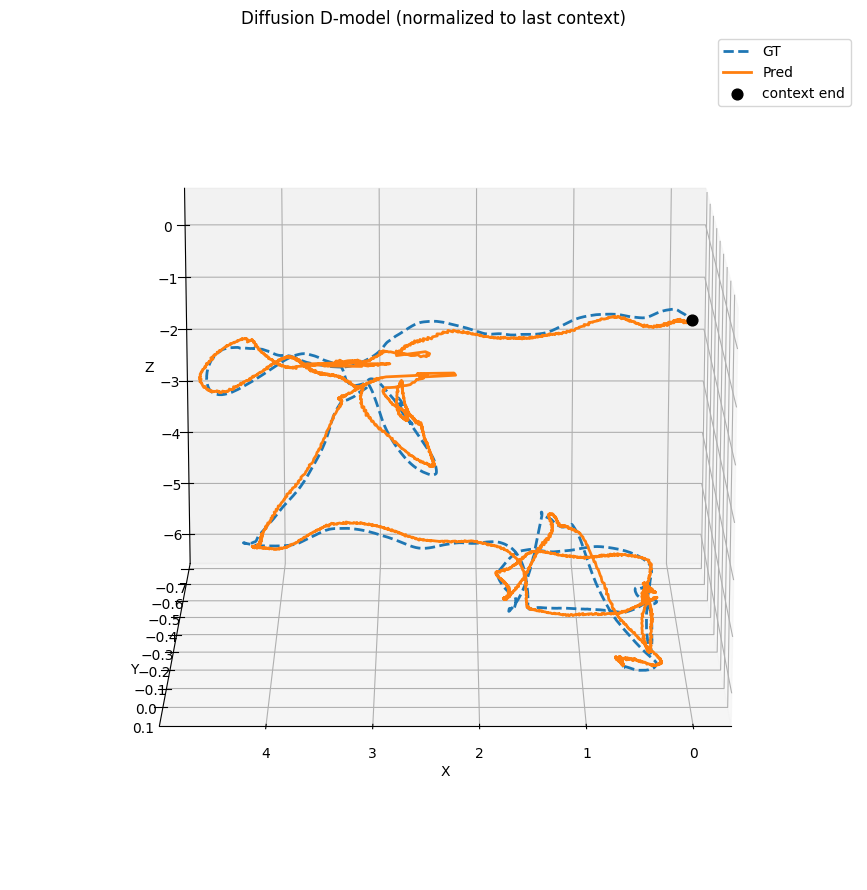

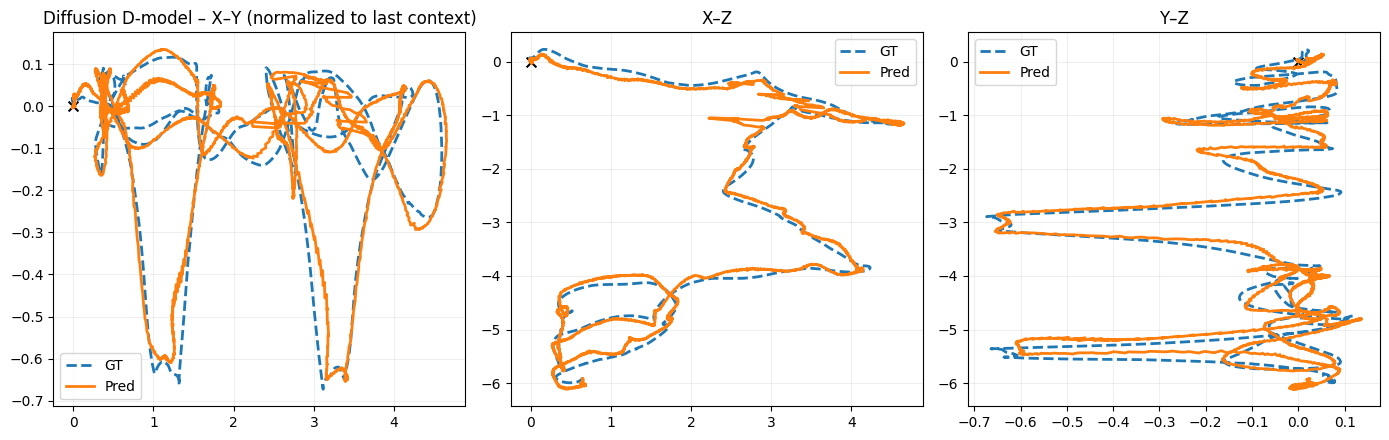

In [66]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_D, mask_D = predict_full_file_diffusion_cross(arr=arr,model=model_D, sched=sched_D, mu=mu_D, sig=sig_D,label_const=1,seq_in=30, seq_out=30,
    step=3,batch_pred=256,sample_steps=100,guide_w=2.0,device=DEVICE)

plot_3d(gt=arr, pred=pred_D, title="Diffusion D-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_D, title="Diffusion D-model", xyz_idx=(16,17,18))

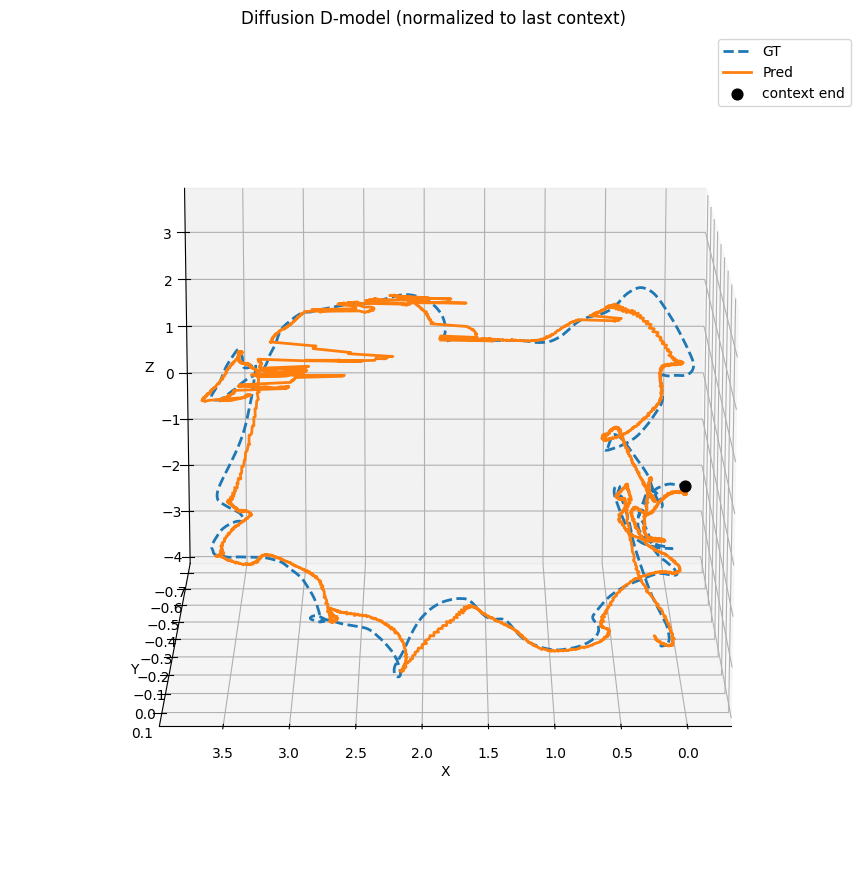

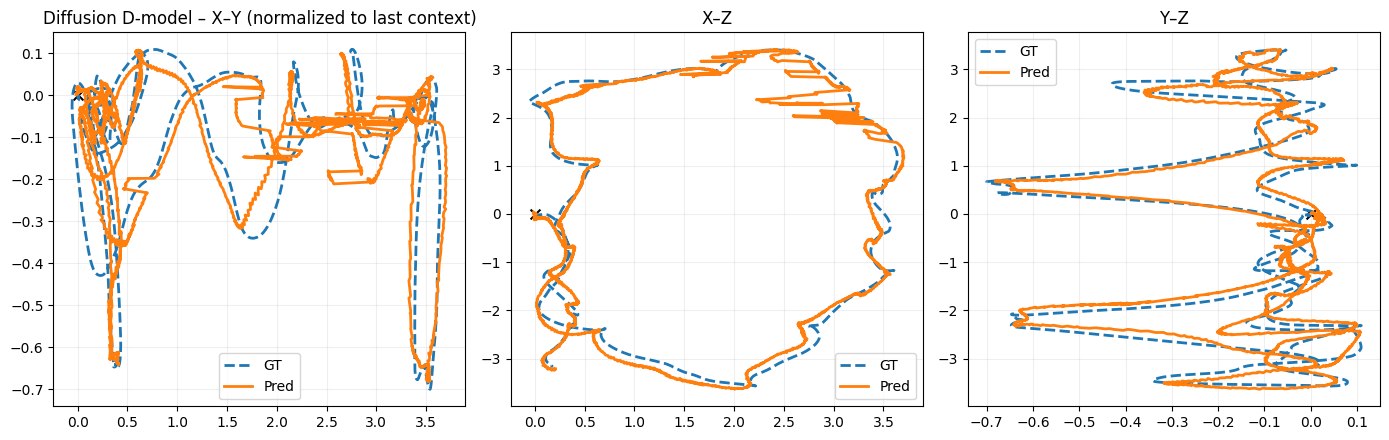

In [67]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D2_All_CSVs/cleaned_Take 080317_Sub2_Circle3 10.41.27 AM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_D, mask_D = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_D, sched=sched_D, mu=mu_D, sig=sig_D,
    label_const=1,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_D, title="Diffusion D-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_D, title="Diffusion D-model", xyz_idx=(16,17,18))

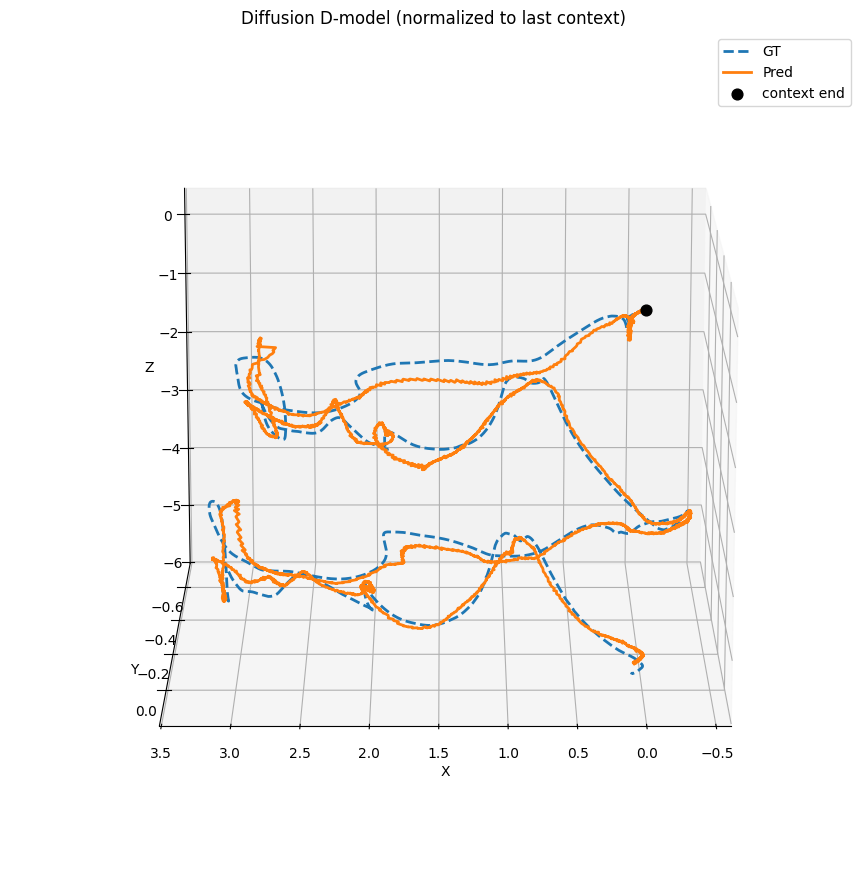

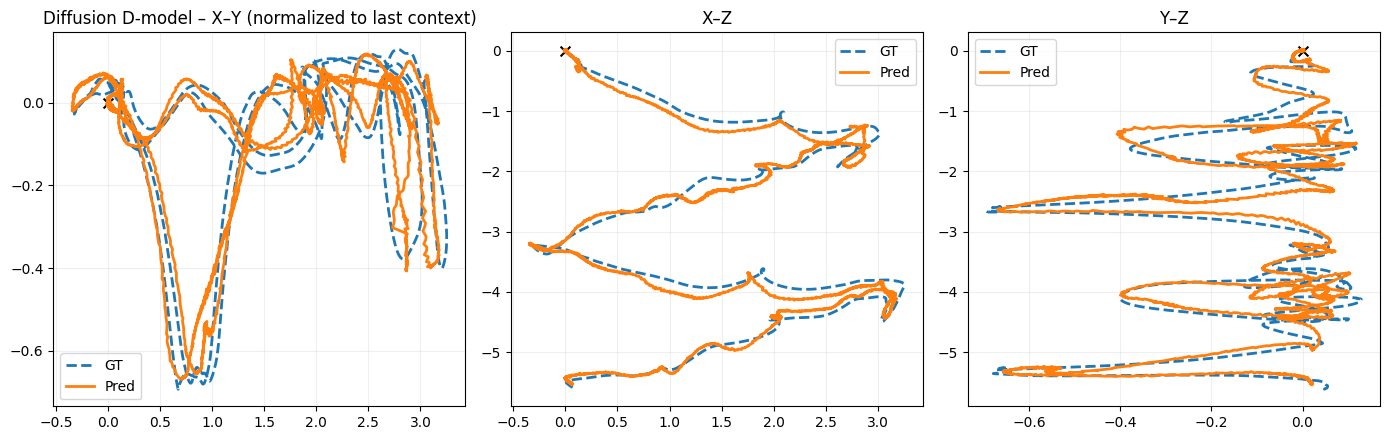

In [68]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D7_All_CSVs/cleaned_Take 091317_Sub8_NewZigZag2 01.10.40 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_N, mask_N = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_N, sched=sched_N, mu=mu_N, sig=sig_N,
    label_const=0,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_N, title="Diffusion D-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_N, title="Diffusion D-model", xyz_idx=(16,17,18))


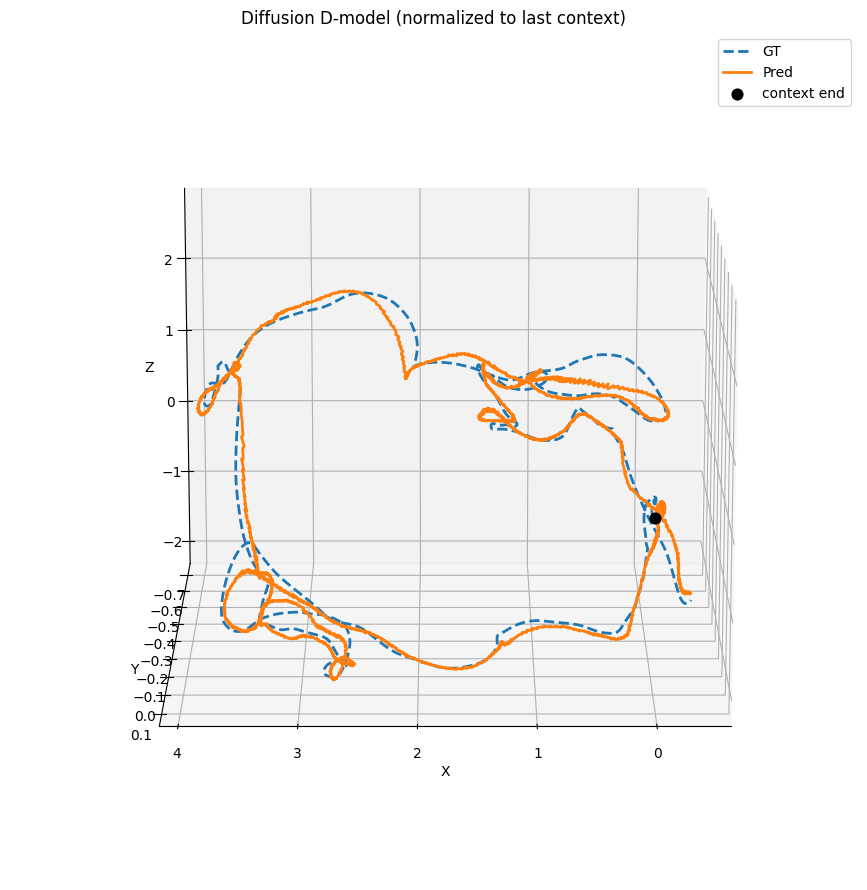

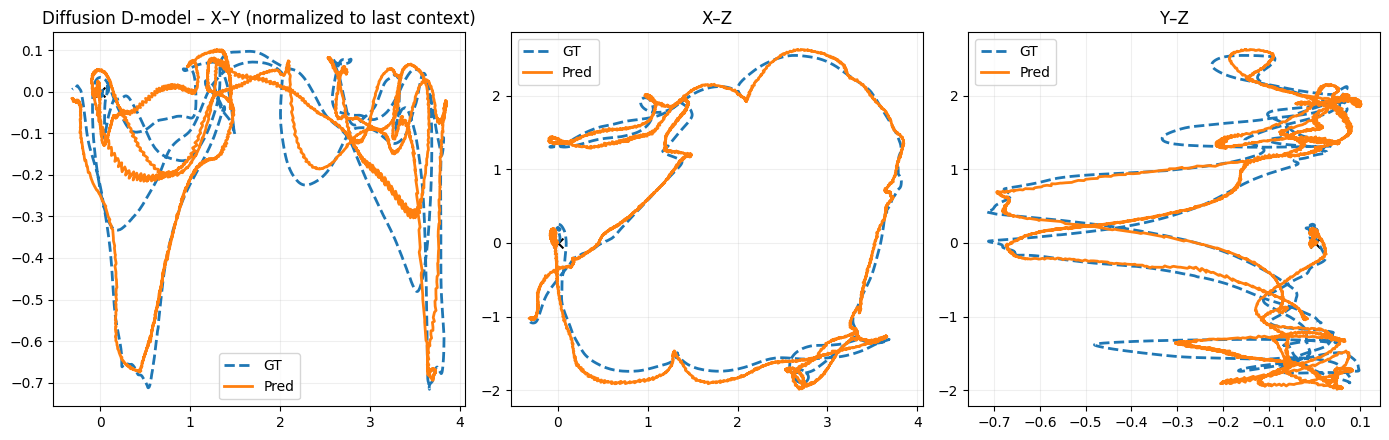

In [70]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_N, mask_N = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_N, sched=sched_N, mu=mu_N, sig=sig_N,
    label_const=0,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_N, title="Diffusion D-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_N, title="Diffusion D-model", xyz_idx=(16,17,18))


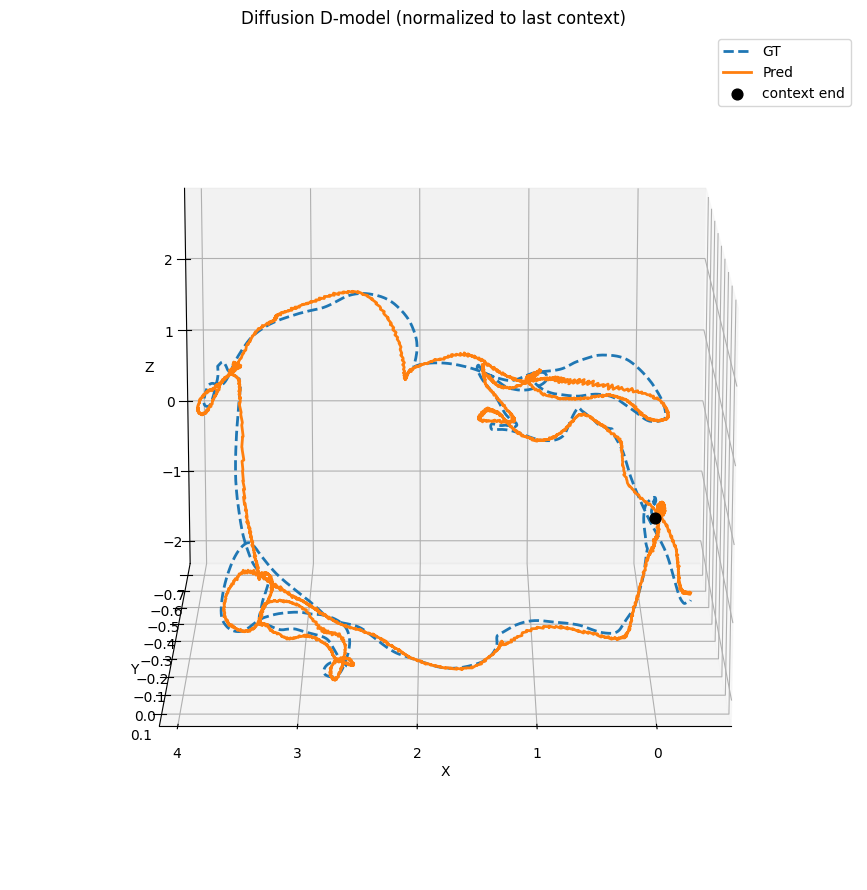

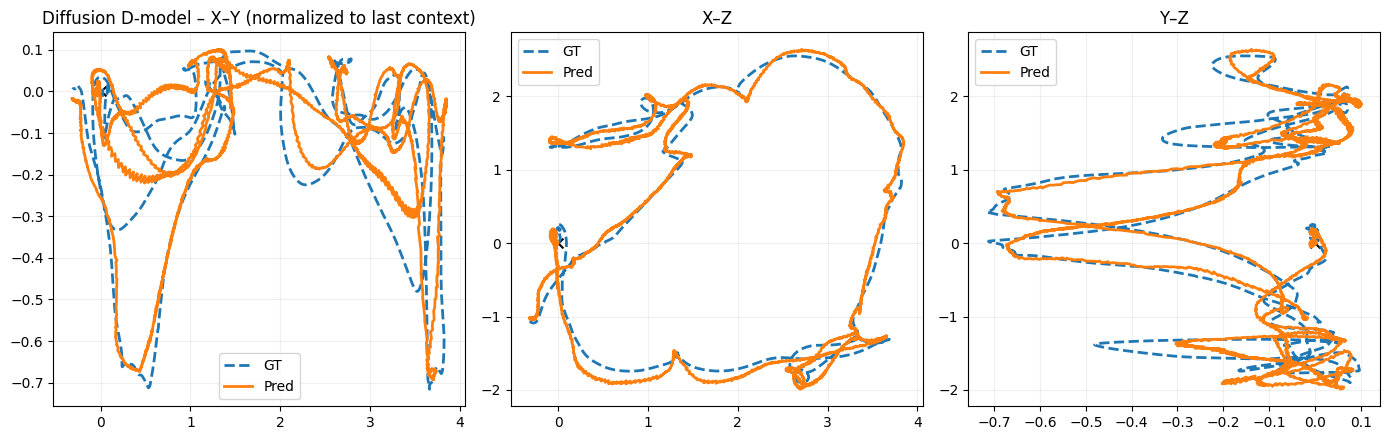

In [71]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_N, mask_N = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_N, sched=sched_N, mu=mu_N, sig=sig_N,
    label_const=0,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_N, title="Diffusion D-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_N, title="Diffusion D-model", xyz_idx=(16,17,18))


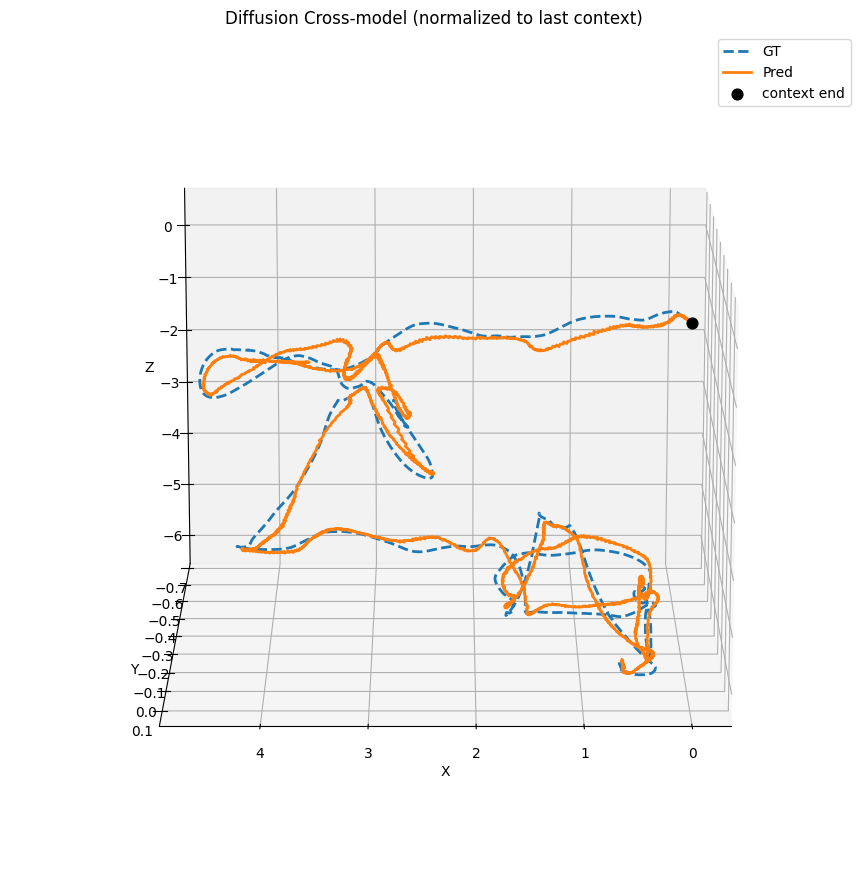

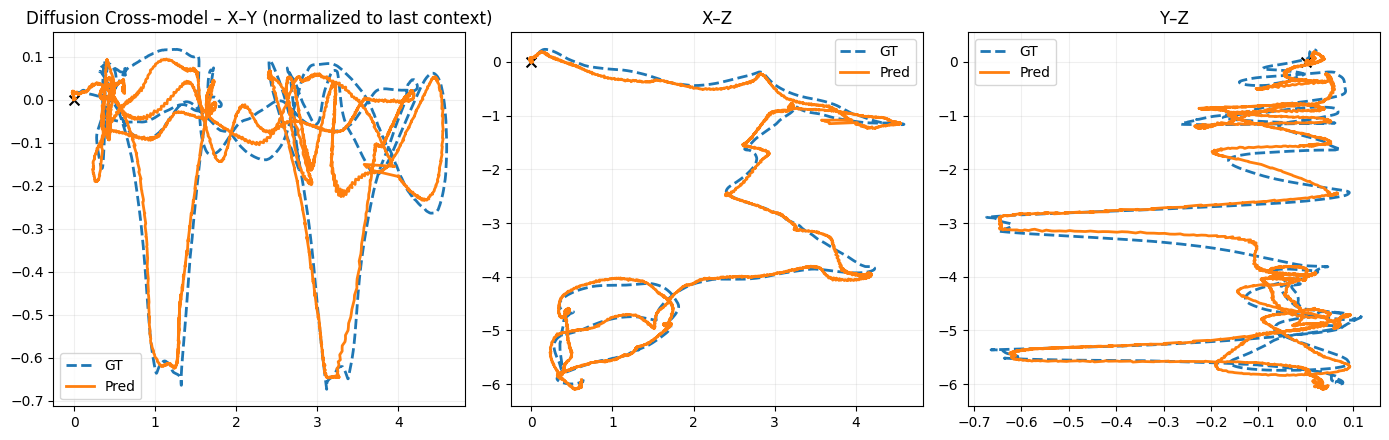

In [59]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_N, mask_N = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_N, sched=sched_N, mu=mu_N, sig=sig_N,
    label_const=0,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_N, title="Diffusion Cross-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_N, title="Diffusion Cross-model", xyz_idx=(16,17,18))


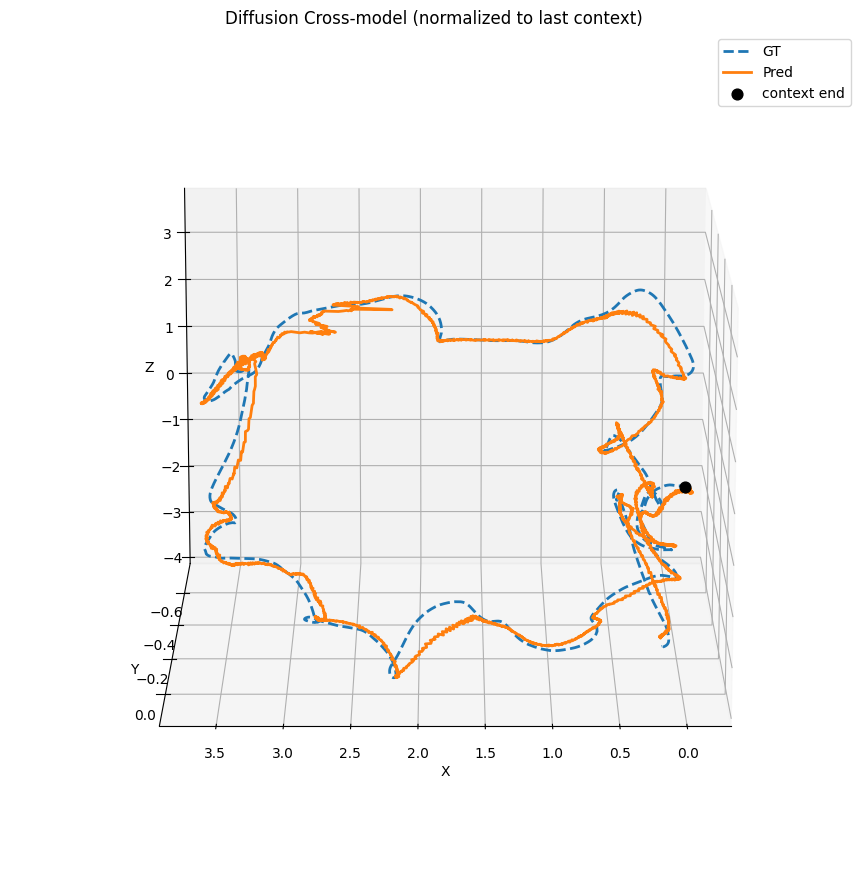

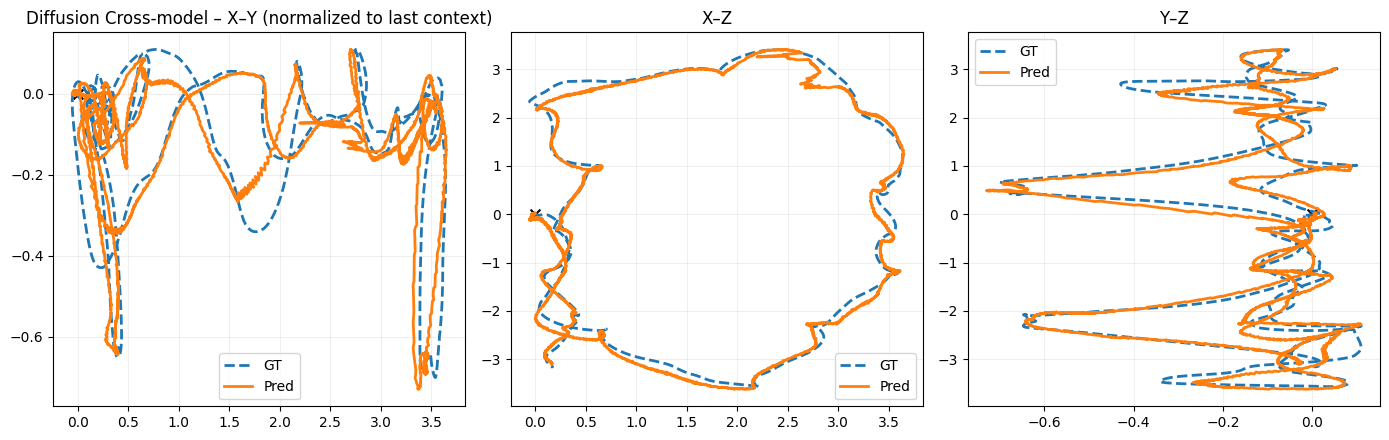

In [72]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D2_All_CSVs/cleaned_Take 080317_Sub2_Circle3 10.41.27 AM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_N, mask_N = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_N, sched=sched_N, mu=mu_N, sig=sig_N,
    label_const=0,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_N, title="Diffusion Cross-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_N, title="Diffusion Cross-model", xyz_idx=(16,17,18))

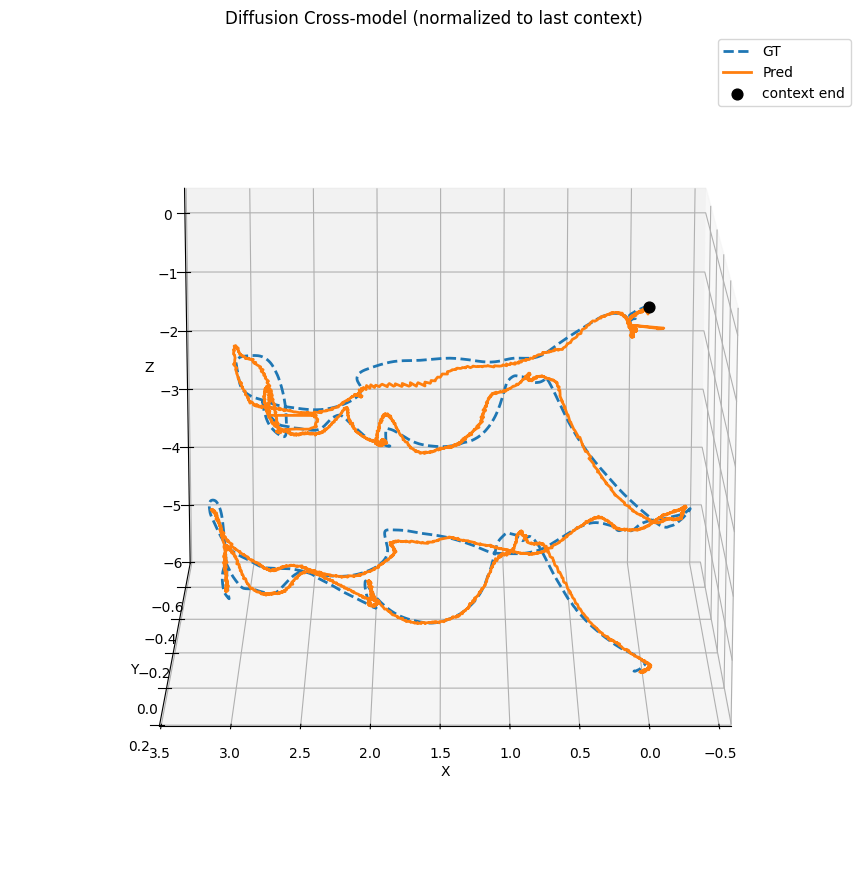

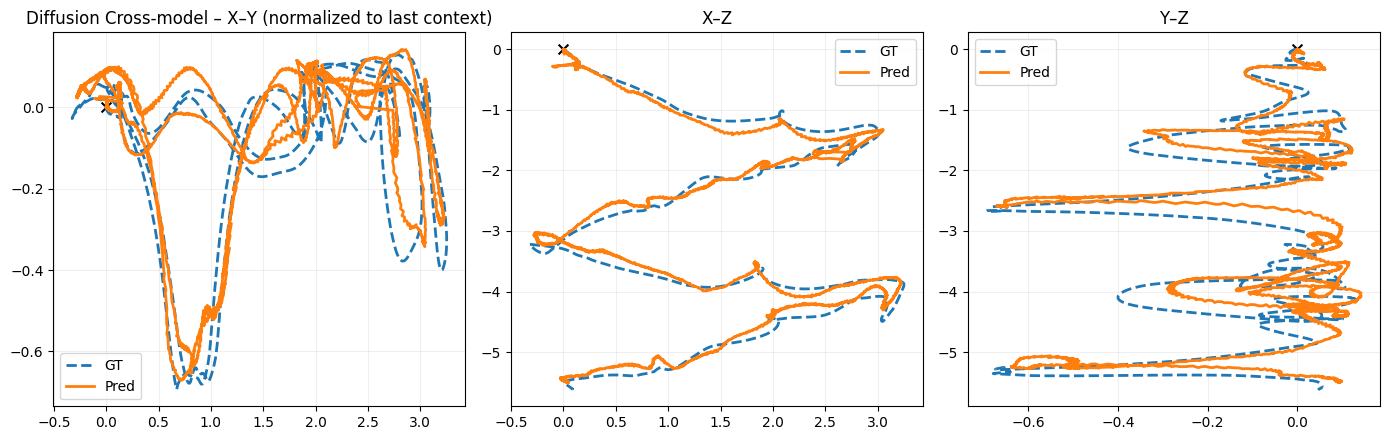

In [73]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D7_All_CSVs/cleaned_Take 091317_Sub8_NewZigZag2 01.10.40 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_D, mask_D = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_D, sched=sched_D, mu=mu_D, sig=sig_D,
    label_const=1,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)
plot_3d(gt=arr, pred=pred_D, title="Diffusion Cross-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_D, title="Diffusion Cross-model", xyz_idx=(16,17,18))

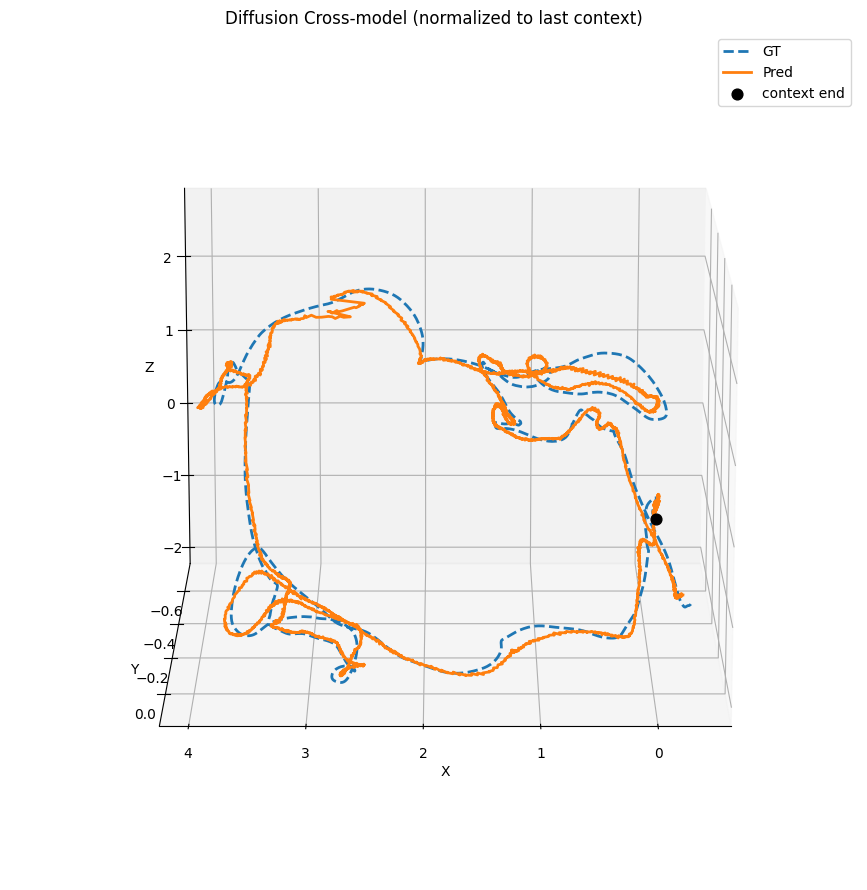

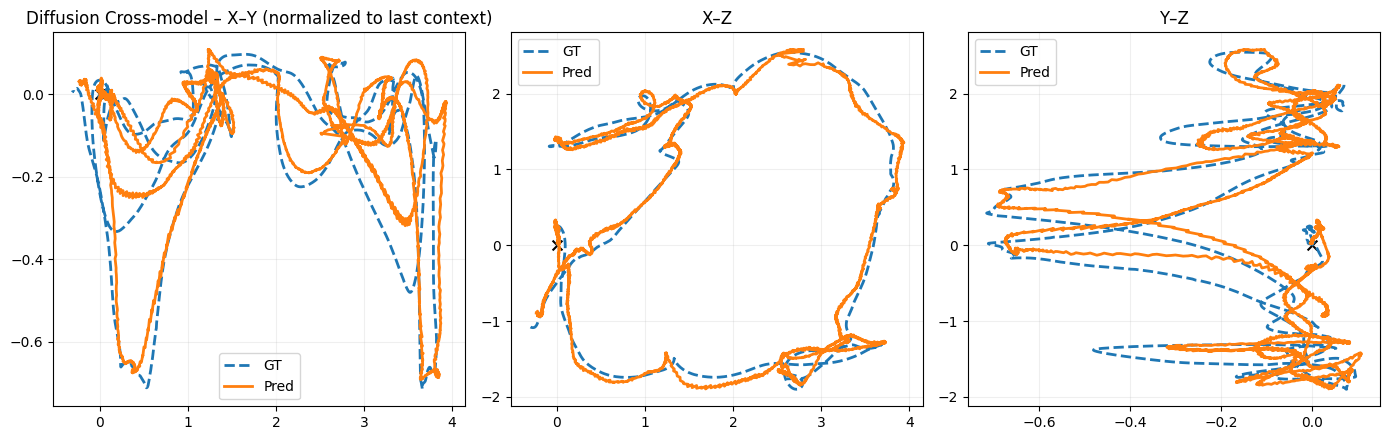

In [74]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle2 01.11.06 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_D, mask_D = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_D, sched=sched_D, mu=mu_D, sig=sig_D,
    label_const=1,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_D, title="Diffusion Cross-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_D, title="Diffusion Cross-model", xyz_idx=(16,17,18))

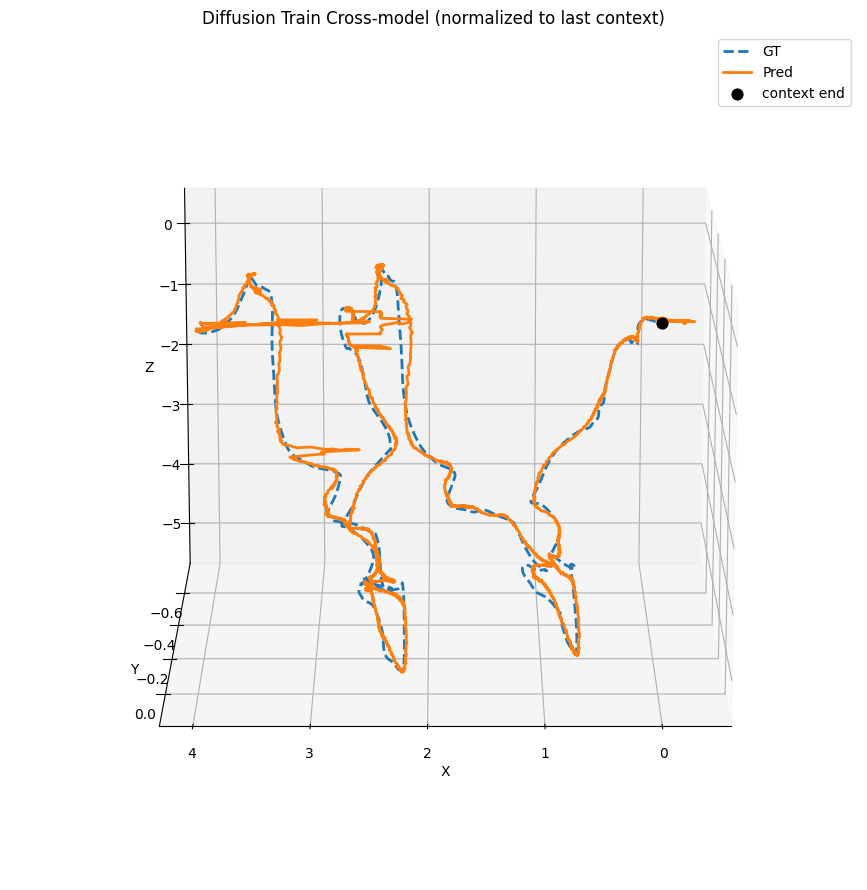

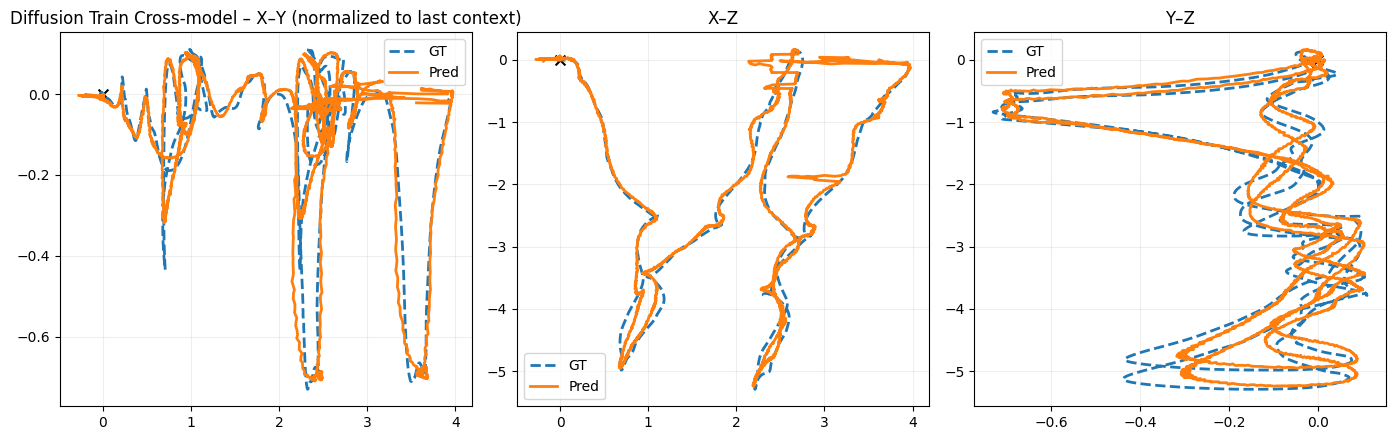

In [75]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_train3 01.00.35 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_D, mask_D = predict_full_file_diffusion_cross(arr=arr,model=model_D, sched=sched_D, mu=mu_D, sig=sig_D,label_const=1,seq_in=30, seq_out=30,
    step=3,batch_pred=256,sample_steps=100,guide_w=2.0,device=DEVICE)

plot_3d(gt=arr, pred=pred_D, title="Diffusion Train Cross-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_D, title="Diffusion Train Cross-model", xyz_idx=(16,17,18))

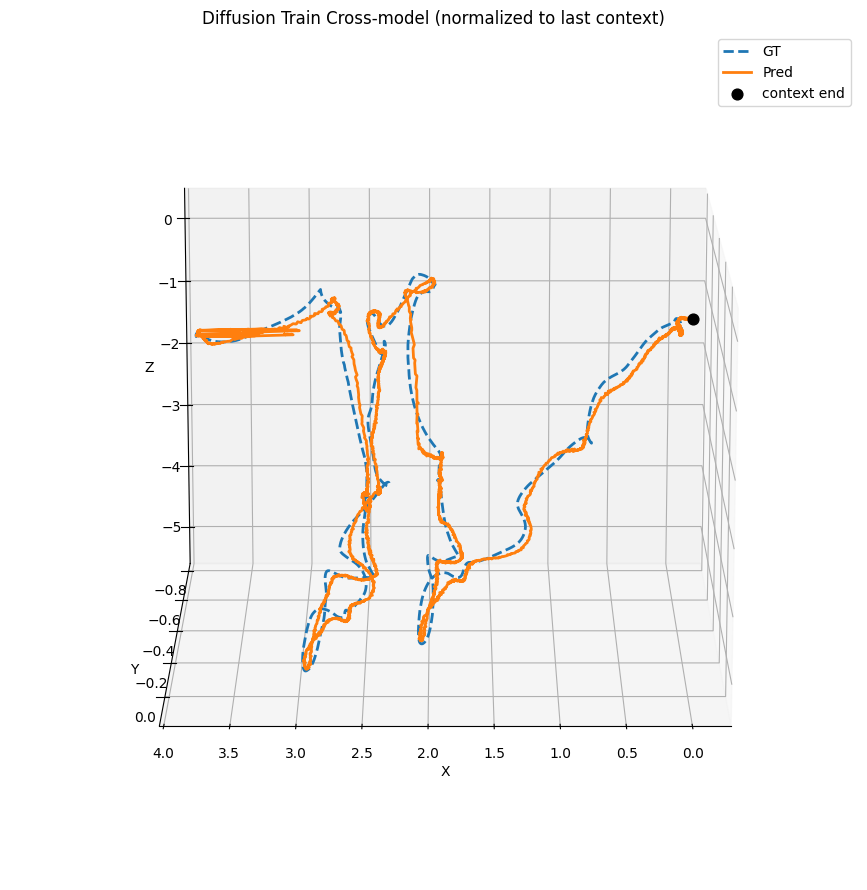

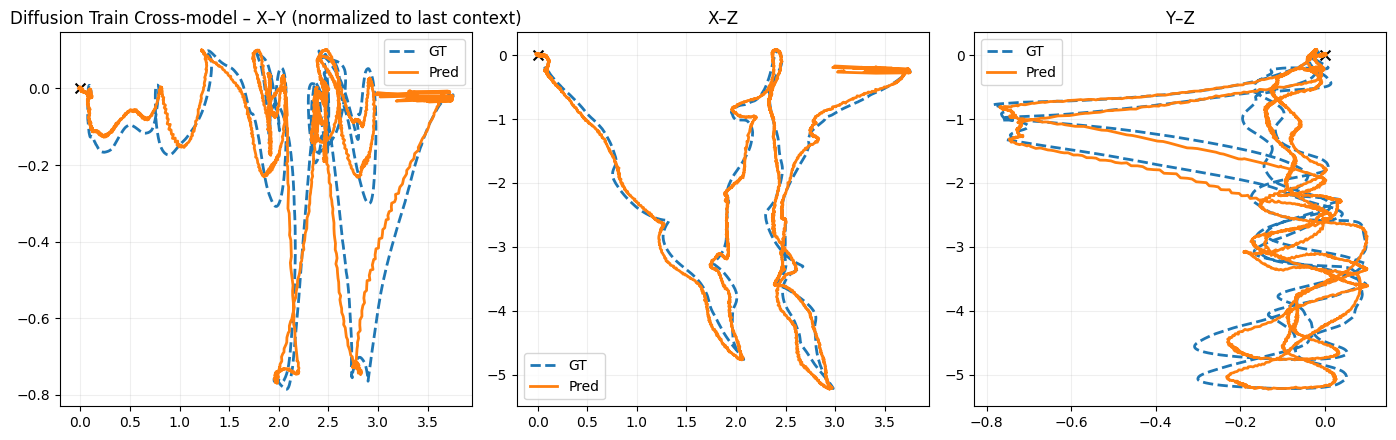

In [64]:
file_path = "/content/drive/MyDrive/Dance_clean_data/D3_All_CSVs/cleaned_Take 090617_Sub4_train1 01.41.03 PM edit.npy"
arr = np.load(file_path).astype(np.float32)

pred_N, mask_N = predict_full_file_diffusion_cross(
    arr=arr,
    model=model_N, sched=sched_N, mu=mu_N, sig=sig_N,
    label_const=0,
    seq_in=30, seq_out=30,
    step=3,
    batch_pred=256,
    sample_steps=100,
    guide_w=2.0,
    device=DEVICE
)

plot_3d(gt=arr, pred=pred_N, title="Diffusion Train Cross-model", xyz_idx=(16,17,18))
plot_2d(gt=arr, pred=pred_N, title="Diffusion Train Cross-model", xyz_idx=(16,17,18))
